# pair trading

In [1]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

In [53]:
def check_cointegration(tic1, tic2, from_date=None, to_date=None):
    api_key = os.getenv('ALPHA_VANTAGE_API_KEY')
    ts = TimeSeries(key=api_key, output_format='pandas')
    
    data1, _ = ts.get_daily_adjusted(symbol=tic1, outputsize='full')
    data2, _ = ts.get_daily_adjusted(symbol=tic2, outputsize='full')
    
    series1 = data1['5. adjusted close']
    series2 = data2['5. adjusted close']
    data = pd.concat([series1, series2], axis=1, join='inner')
    data.columns = [tic1, tic2]
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()

    # Apply date filtering if specified
    if from_date:
        data = data[data.index >= pd.to_datetime(from_date)]
    if to_date:
        data = data[data.index <= pd.to_datetime(to_date)]

    X = sm.add_constant(data[tic2])
    model = sm.OLS(data[tic1], X).fit()
    hedge_ratio = model.params[tic2]
    spread = data[tic1] - hedge_ratio * data[tic2]

    plt.figure(figsize=(12, 6))
    plt.plot(spread, label='Spread')
    plt.axhline(spread.mean(), color='r', linestyle='--', label='Mean')
    plt.title(f"Spread Between {tic1} and {tic2} (Alpha Vantage)\ hedge ratio: {hedge_ratio}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.show()

    adf_result = sm.tsa.adfuller(spread)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"P-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value}")


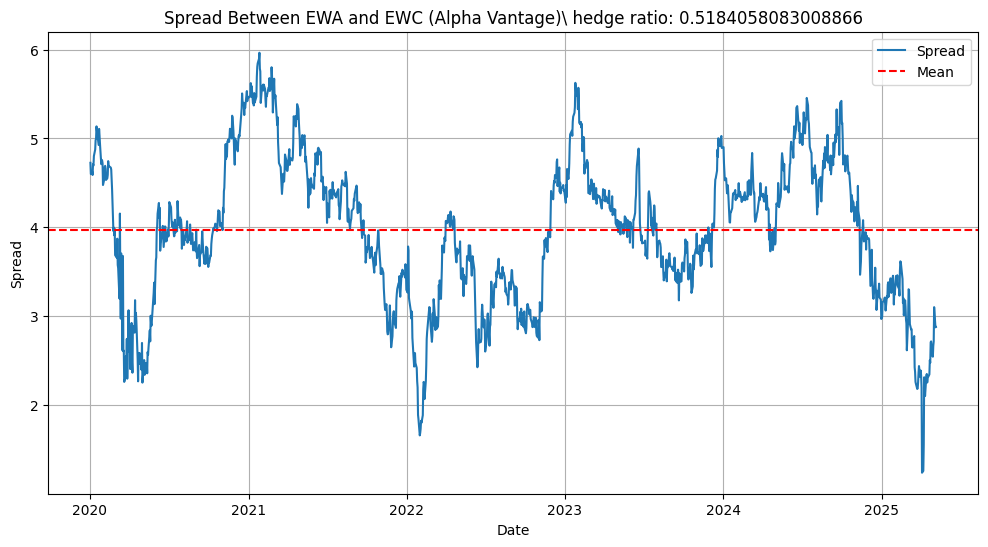

ADF Statistic: -2.956566984375773
P-value: 0.039154421476221814
Critical Values:
  1%: -3.4352578040092436
  5%: -2.863707411237363
  10%: -2.5679239356703


In [54]:
check_cointegration('EWA', 'EWC', from_date = "2020-01-01")

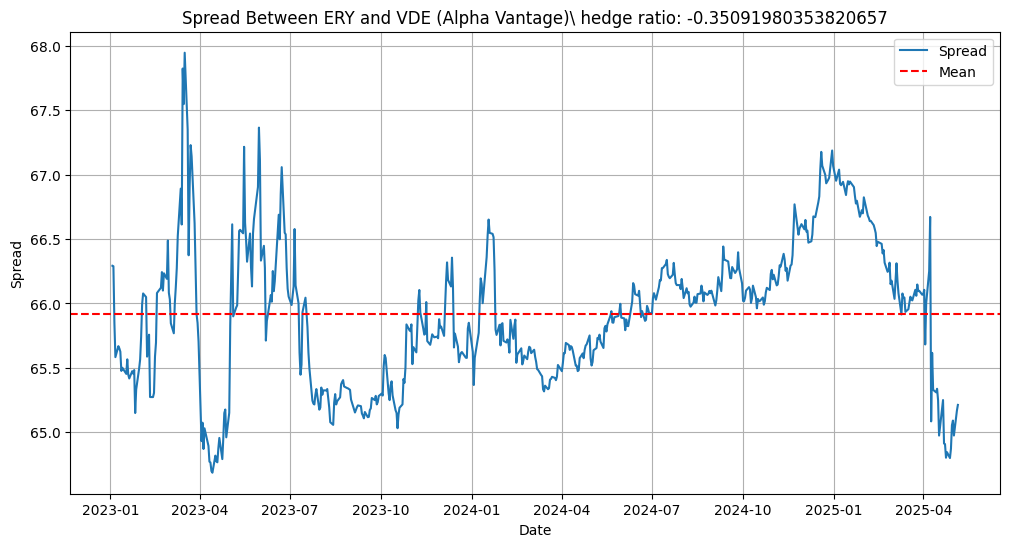

ADF Statistic: -3.777965888266517
P-value: 0.0031409713957377635
Critical Values:
  1%: -3.4415777369651717
  5%: -2.866493255736561
  10%: -2.569407951640003


In [55]:
check_cointegration('ERY', 'VDE', from_date = "2023-01-01") #'VTI', 'SCHB' # 'XLE', 'VDE' # 'EWA', 'EWC'